<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Google Colab with GitHub

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

import torchvision
import torch
from torch.utils.data import DataLoader

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

path_github = "IMAS_MachineLearning_Workshop-Image_Analysis"
if not os.path.isdir(path_github):
    !git clone https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis.git

%cd IMAS_MachineLearning_Workshop-Image_Analysis/code/

!git fetch
!git pull origin main

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/IMAS_MachineLearning_Workshop-Image_Analysis/code
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
 * branch            main       -> FETCH_HEAD
Already up to date.


In [4]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, imshow_tensor
from loader import WaldoLoader
from model import Waldo_model
from training import train_model

In [5]:
path_dataset_folder = "../dataset"
path_image_folder = "images"
fname_annotation = "annotations.csv"
extension = ".jpg"
ratio_train_valid_dataset = 0.6
ratio_valid_dataset = 0.2
int_seed_split = 7109
size_patch = 240
sequence_data_augmentation = None #Sequence([RandomTranslate(0.2)]) #RandomHorizontalFlip(0.5)]) #, RandomTranslate(0.2)])
size_batch = 16

In [6]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the dataset...".format(len(list_fname_im)))

Found 29 images in the dataset...


In [7]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.head())

Getting annotations...
  filename  width  height  class  xmin  ymin  xmax  ymax
0  001.jpg   2048    1251  waldo   706   513   743   562
1  002.jpg   1286     946  waldo    82   521   107   554
2  003.jpg   2048    1346  waldo  1390   463  1422   500
3  004.jpg   2048    1272  waldo  1484   279  1507   306
4  005.jpg   2100    1760  waldo   882   594   913   634


In [8]:
print("Saving binary mask from annotations as ground-truth...")
for index, row in df_annotations.iterrows():
    fname_im = row["filename"]
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    if not os.path.isfile(path_gt):
        print("... Ground-truth of: {} ...".format(fname_im))
        mask = create_binary_mask(bbox_coords=row[["xmin", "ymin", "xmax", "ymax"]],
                              im_ref_width=row["width"],
                              im_ref_height=row["height"])
        plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...


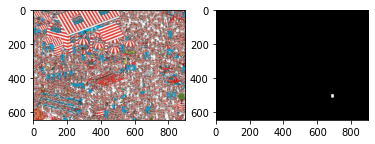

In [10]:
fig = plt.figure()

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_im))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_im.split(".jpg")[0] + "_gt.png"))
np_gt = np.array(gt)
plt.imshow(np_gt)

plt.show()

In [11]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate, df_fname_test = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split),
             [int(ratio_train_valid_dataset*len(df_fname)),
              int((1-ratio_valid_dataset)*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"
df_annotations.loc[df_annotations["filename"].isin(df_fname_test), "subset"] = "testing"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554  validation
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306     testing
4  005.jpg   2100    1760  waldo   882   594   913   634    training


In [12]:
width_largest = df_annotations["width"].max()
height_ = df_annotations[df_annotations["width"] == width_largest]["height"].tolist()[0]
size_img = (width_largest, height_)

In [13]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"]
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Resizing all images to same dimensions: (2953, 2088) pixels^2 ...


In [14]:
len(dataset_train)

2106

In [15]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)

In [ ]:
#image_expl, label_expl = iter(loader_train).next()
#print(image_expl.mean(), image_expl.std())
#print(label_expl.unique(), label_expl.size(), image_expl.size())

(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 7
(3, 240, 240) (240, 240) [0. 1.] 1
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 9
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 3
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 1
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 0
(3, 240, 240) (240, 240) [0. 1.] 9
(3, 240, 240) (240, 240) [0.] None
(3, 240, 240) (240, 240) [0. 1.] 9
tensor(2.2683e-09) tensor(1.0000)
tensor([  0., 120., 153., 166., 171., 173., 175., 176., 178., 183., 194., 202.]) torch.Size([16, 4]) torch.Size([16, 3, 240, 240])


In [16]:
model = Waldo_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [17]:
model_trained = train_model(model, optimizer, loader_train, dataset_validation=None, n_epoch=15)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train_loss 281.983
train_loss 232.214
train_loss 166.202
train_loss 129.364
train_loss 109.440
train_loss 87.991
train_loss 67.714
train_loss 79.924
train_loss 62.988
train_loss 73.938
train_loss 72.437
train_loss 58.949
train_loss 62.753
train_loss 60.818
tensor([[148.1640, 205.6233, 147.9597, 199.6517],
        [ 17.2377,  25.6115,  17.1283,  25.1007],
        [ 16.3825,  23.3606,  16.2940,  22.1316],
        [ 43.1272,  65.1522,  42.9487,  64.4377],
        [ 17.6624,  25.8440,  17.4644,  24.5976],
        [152.8949, 226.7494, 152.6662, 227.7858],
        [ 16.3025,  24.0299,  16.1331,  22.5376],
        [149.7398, 209.2262, 150.2317, 188.0172],
        [ 16.3495,  25.5908,  16.1904,  24.2997],
        [ 17.7891,  26.3429,  17.5972,  25.5782],
        [ 17.2272,  25.1226,  17.1919,  23.9558],
        [ 15.6740,  23.0387,  15.5636,  21.1018],
        [ 23.4516,  36.1179,  23.3358,  32.9231],
        [131.4004, 207.4832, 132.1853, 193.5915],
        [148.1640, 205.6233, 147.9597, 199.

Waldo_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats